In [1]:
# import libraries
import torch
import torchinfo
import torchvision

from torch import nn
from torch.nn import Conv2d, ReLU, MaxPool2d, Flatten, Linear
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import os
import wget
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from pathlib import Path
from PIL import Image
from zipfile import ZipFile
from tqdm.auto import tqdm


/home/jason/anaconda3/envs/tadac/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
## DATA DIRECTORY

# data directory
DATA_DIR = Path("../../data")
if not DATA_DIR.is_dir():
    DATA_DIR.mkdir(parents=True, exist_ok=True)

# logging directory
LOG_DIR = Path("../../logs")
if not LOG_DIR.is_dir():
    LOG_DIR.mkdir(parents=True, exist_ok=True)

# models directory
MODEL_DIR = Path("../../models")
if not MODEL_DIR.is_dir():
    MODEL_DIR.mkdir(parents=True, exist_ok=True)

# save model
CHECKPOINT_FILE_PATH = MODEL_DIR.joinpath(f"04_tinyvgg_epochs_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pt")

In [3]:
### LOGGING CONFIGURATION
LOG_FILE_PATH = LOG_DIR.joinpath(f"04_tinyvgg6_nn_pt_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log")
logging.basicConfig(
    level=logging.INFO,
    datefmt="%a, %d %b %Y %H:%M:%S",
    format="[%(asctime)s.%(msecs)03d] %(levelname)s - %(message)s",
    handlers=[
        logging.FileHandler(filename=LOG_FILE_PATH, mode="w"),
        logging.StreamHandler()
    ]
)

In [4]:
### CHECK VERSIONS
logging.info(f"Torch version: {torch.__version__}")
logging.info(f"Torchvision version: {torchvision.__version__}")

# check device
device = "cuda" if torch.cuda.is_available() else "cpu"
logging.info(f"Device: {device}")

# check num cpus
num_cpus = os.cpu_count()
logging.info(f"Num of CPUs: {num_cpus}")

[Thu, 31 Aug 2023 23:30:57.531] INFO - Torch version: 1.12.1
[Thu, 31 Aug 2023 23:30:57.532] INFO - Torchvision version: 0.13.1
[Thu, 31 Aug 2023 23:30:58.373] INFO - Device: cuda
[Thu, 31 Aug 2023 23:30:58.374] INFO - Num of CPUs: 8


In [5]:
### DOWNLOAD DATASETS
DATASET_URL = "https://storage.googleapis.com/ztm_tf_course/food_vision/pizza_steak.zip"

DATASET_ZIPFILE_NAME = "pizza_steak.zip"
DATASET_ZIPFILE_PATH = DATA_DIR.joinpath(DATASET_ZIPFILE_NAME)

DATASET_FOLDER_NAME = "pizza_steak"
DATASET_FOLDER_PATH = DATA_DIR.joinpath(DATASET_FOLDER_NAME)

In [6]:
### DOWLOADING

if DATASET_ZIPFILE_PATH.is_file():
    logging.info(f"The file {DATASET_ZIPFILE_NAME} already exists. Skipped downloading.")
else:
    logging.info(f"The file {DATASET_ZIPFILE_NAME} is downloading...")
    try:
        wget.download(url=DATASET_URL, out=str(DATA_DIR))
    except Exception as error:
        logging.error(f"Caught this error {error} during downloading !!!")

    logging.info(f"The file {DATASET_ZIPFILE_NAME} is downloaded successfully.")

[Thu, 31 Aug 2023 23:30:58.395] INFO - The file pizza_steak.zip already exists. Skipped downloading.


In [7]:
## EXTRACTING

if DATASET_FOLDER_PATH.is_dir():
    logging.info(f"The {DATASET_ZIPFILE_NAME} is extracted. Skipped extracting.")
else: 
    logging.info(f"The {DATASET_ZIPFILE_NAME} is extracting...")
    try:
        zipper = ZipFile(DATASET_ZIPFILE_PATH)
        zipper.extractall(path=str(DATA_DIR))
        zipper.close()
    except Exception as error:
        logging.info(f"Caught this error {error} during extracting !!!")

[Thu, 31 Aug 2023 23:30:58.407] INFO - The pizza_steak.zip is extracted. Skipped extracting.


In [8]:
# BATCH SIZE
BATCH_SIZE = 32
logging.info(f"Batch size: {BATCH_SIZE}")

[Thu, 31 Aug 2023 23:30:58.418] INFO - Batch size: 32


In [9]:
# train directory
TRAIN_DIR = DATASET_FOLDER_PATH.joinpath("train")
os.listdir(TRAIN_DIR)

['pizza', 'steak']

In [10]:
# check images in train directory
for filepaths, dirnames, filenames in os.walk(TRAIN_DIR):
    if len(filenames) > 0:
        logging.info(f"There are {len(filenames)} in {filepaths}")

[Thu, 31 Aug 2023 23:30:58.446] INFO - There are 750 in ../../data/pizza_steak/train/pizza
[Thu, 31 Aug 2023 23:30:58.447] INFO - There are 750 in ../../data/pizza_steak/train/steak


In [11]:
# test directory
TEST_DIR = DATASET_FOLDER_PATH.joinpath("test")
os.listdir(TEST_DIR)

['pizza', 'steak']

In [12]:
# check images in test directory
for filepaths, dirnames, filenames in os.walk(TEST_DIR):
    if len(filenames) > 0:
        logging.info(f"There are {len(filenames)} in {filepaths}")

[Thu, 31 Aug 2023 23:30:58.473] INFO - There are 250 in ../../data/pizza_steak/test/pizza
[Thu, 31 Aug 2023 23:30:58.474] INFO - There are 250 in ../../data/pizza_steak/test/steak


In [13]:
### IMAGE LOADER

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(0.2),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.465, 0.406],
                         std=[0.229, 0.225, 0.224])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.465, 0.406],
                         std=[0.229, 0.225, 0.224])
])

train_dataset = ImageFolder(TRAIN_DIR, transform=train_transform)
test_dataset = ImageFolder(TEST_DIR, transform=test_transform)

In [14]:
### CLASS NAMES
class_names = sorted(train_dataset.classes)
logging.info(f"Class names: {class_names}")

[Thu, 31 Aug 2023 23:30:58.496] INFO - Class names: ['pizza', 'steak']


In [15]:
### DATALOADER

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=num_cpus, shuffle=True)

test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=num_cpus, shuffle=False)

In [16]:
### VISUALISATION
images, labels = next(iter(train_dataloader))

images.shape, labels.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

(-0.5, 223.5, 223.5, -0.5)

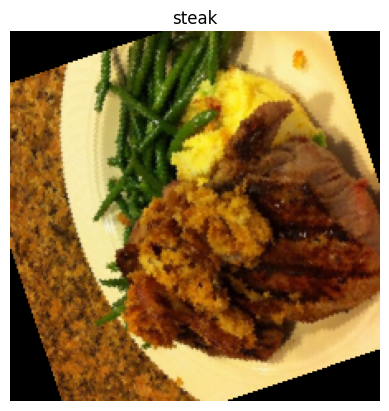

In [17]:
# plot one image from DataLoader
image = images[0]

# from PyTorch shapes to Matplotlib shape
image_np = image.permute(2,1,0).numpy()

# mean 
mean = [0.485, 0.456, 0.406]

# std 
std = [0.229, 0.224, 0.225]

# convert the normalized image to the normal image
image = image_np * std + mean

# clipping 
image = np.clip(image, 0, 1)

plt.imshow(image)
plt.title(f"{class_names[labels[0]]}")
plt.axis(False)

In [18]:
## MODELING

class TinyVGG(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=2, stride=1, padding=0),
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=0),
            nn.MaxPool2d(kernel_size = 2)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=0),
            nn.MaxPool2d(kernel_size = 2),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=2, stride=1, padding=0),
            nn.MaxPool2d(kernel_size = 2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=13*13*hidden_units, out_features=len(class_names))
        )
    
    def forward(self, x: torch.Tensor):

        x = self.block_1(x)
        # print(f"block_1: {x.shape}")
        x = self.block_2(x)
        # print(f"block_2: {x.shape}")
        x = self.classifier(x)
        # print(f"classifier: {x.shape}")
        return x



In [19]:
# create an instance of the model
model = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(train_dataset.classes))

# send model to device
model.to(device)

# loss_fn
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)

# epochs
epochs = 50

results_dict = {
    "loss": [], 
    "accuracy": [],
    "val_loss": [],
    "val_accuracy": []
}

for epoch in range(epochs):

    ## TRAINING
    accumulated_train_acc = 0.0
    accumulated_train_loss = 0.0
    accumulated_train_batches = 0

    for input, output in train_dataloader:

        # send data to device
        input = input.to(device)
        output = output.to(device)

        # train mode
        model.train()

        # forward
        y_logits = model(input)

        # calculate loss
        loss = loss_fn(y_logits.float(), output.long())
        accumulated_train_loss += loss.item()

        # calculate accuracy
        acc = torch.eq(output, torch.argmax(torch.softmax(y_logits, dim=1), dim=1)).sum().item()
        accumulated_train_acc += acc 

        # reset gradient
        optimizer.zero_grad()

        # backward
        loss.backward()

        # update parameters
        optimizer.step()

        # update batches
        accumulated_train_batches += 1


    ## EVAL
    accumulated_test_acc = 0.0
    accumulated_test_loss = 0.0
    accumulated_test_batches = 0
    # eval mode
    model.eval()
    with torch.inference_mode():
        for input, output in test_dataloader:

            # send data to device
            input = input.to(device)
            output = output.to(device)

            # forward
            y_logits = model(input)

            # calculate loss
            loss = loss_fn(y_logits.float(), output.long())
            accumulated_test_loss += loss.item()

            # calculate accuracy
            acc = torch.eq(output, torch.argmax(torch.softmax(y_logits, dim=1), dim=1)).sum().item()
            accumulated_test_acc += acc 

            # update batches
            accumulated_test_batches += 1

    # train info
    train_loss = accumulated_train_loss / accumulated_train_batches
    train_acc = accumulated_train_acc / (BATCH_SIZE * len(train_dataloader))

    # update results dict
    results_dict["loss"].append(train_loss)
    results_dict["accuracy"].append(train_acc)
  

    # test info
    test_loss = accumulated_test_loss / accumulated_test_batches
    test_acc = accumulated_test_acc / (BATCH_SIZE * len(test_dataloader))

    # check total size
    # print(f"Train | Total size | 1. {BATCH_SIZE * len(train_dataloader)} | 2. {len(train_dataset)}")
    # print(f"Test | Total size | 1. {BATCH_SIZE * len(test_dataloader)} | 2. {len(test_dataset)}")

    # update results dict
    results_dict["val_loss"].append(test_loss)
    results_dict["val_accuracy"].append(test_acc)

    logging.info(f"Epoch: {epoch + 1} / {epochs} | "
                 f"train loss: {train_loss:.04f} | "
                 f"train acc: {train_acc: 0.3f} | "
                 f"test loss: {test_loss: 0.4f} | "
                 f"test acc: {test_acc: 0.3f}")

torch.save(model.state_dict(), CHECKPOINT_FILE_PATH)
logging.info(f"The checkpoint of the model is saved in {MODEL_DIR} at epochs: {epochs}")


[Thu, 31 Aug 2023 23:31:06.110] INFO - Epoch: 1 / 50 | train loss: 0.6482 | train acc:  0.680 | test loss:  0.5760 | test acc:  0.760
[Thu, 31 Aug 2023 23:31:10.143] INFO - Epoch: 2 / 50 | train loss: 0.5508 | train acc:  0.748 | test loss:  0.4846 | test acc:  0.768
[Thu, 31 Aug 2023 23:31:14.384] INFO - Epoch: 3 / 50 | train loss: 0.5184 | train acc:  0.742 | test loss:  0.4638 | test acc:  0.779
[Thu, 31 Aug 2023 23:31:18.582] INFO - Epoch: 4 / 50 | train loss: 0.5006 | train acc:  0.762 | test loss:  0.4539 | test acc:  0.777
[Thu, 31 Aug 2023 23:31:22.843] INFO - Epoch: 5 / 50 | train loss: 0.4886 | train acc:  0.766 | test loss:  0.4415 | test acc:  0.785
[Thu, 31 Aug 2023 23:31:26.975] INFO - Epoch: 6 / 50 | train loss: 0.4827 | train acc:  0.774 | test loss:  0.4355 | test acc:  0.795
[Thu, 31 Aug 2023 23:31:30.891] INFO - Epoch: 7 / 50 | train loss: 0.4757 | train acc:  0.776 | test loss:  0.4225 | test acc:  0.785
[Thu, 31 Aug 2023 23:31:34.969] INFO - Epoch: 8 / 50 | train l

In [20]:
IMAGE_NAME = "04-pizza-dad.jpeg"

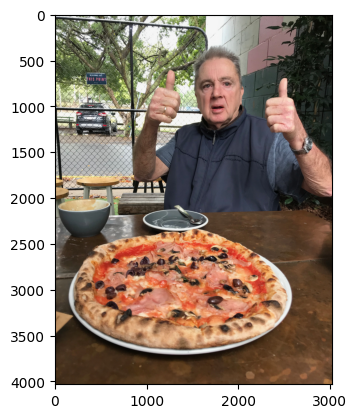

In [21]:
# load an image for testing the model
image = Image.open(DATA_DIR.joinpath(IMAGE_NAME))
plt.imshow(image)

In [22]:
# transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

tranformed_image = transform(image)
tranformed_image.unsqueeze(axis=0).shape

torch.Size([1, 3, 224, 224])

In [23]:
# eval
model.eval()
with torch.inference_mode():
    y_logit = model(tranformed_image.unsqueeze(axis=0).to(device))

y_logit

tensor([[ 0.5347, -0.4135]], device='cuda:0')

y_logit: tensor([[ 0.5347, -0.4135]], device='cuda:0')


(-0.5, 3023.5, 4031.5, -0.5)

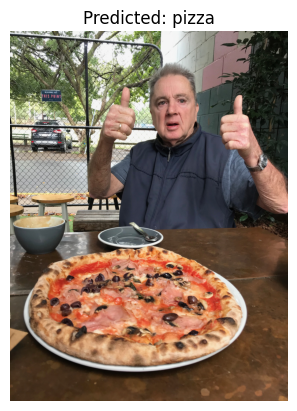

In [24]:
y_pred = torch.argmax(torch.softmax(y_logit, dim=1), dim=1).item()
print(f"y_logit: {y_logit}")
plt.imshow(image)
plt.title(f"Predicted: {class_names[y_pred]}")
plt.axis(False)


In [25]:
# create an instance of the model
new_loaded_model = TinyVGG(input_shape=3, hidden_units=10, output_shape=len(class_names))

# load a saved model from a path
loaded_model = torch.load(CHECKPOINT_FILE_PATH)
new_loaded_model.load_state_dict(loaded_model)


<All keys matched successfully>

y_logit: tensor([[ 0.5347, -0.4135]])


(-0.5, 3023.5, 4031.5, -0.5)

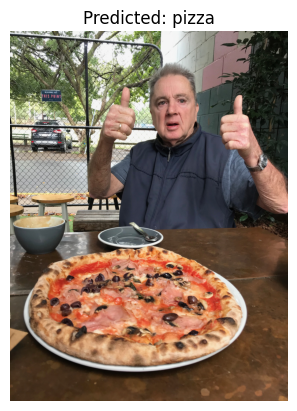

In [26]:
# load an image for testing the model
image = Image.open(DATA_DIR.joinpath(IMAGE_NAME))
plt.imshow(image)

# transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# transform the image
tranformed_image = transform(image)

# eval
new_loaded_model.eval()
with torch.inference_mode():
    y_logit = new_loaded_model(tranformed_image.unsqueeze(axis=0))

# y_pred
y_pred = torch.argmax(torch.softmax(y_logit, dim=1), dim=1).numpy().item()
print(f"y_logit: {y_logit}")
# plot the image
plt.imshow(image)
plt.title(f"Predicted: {class_names[y_pred]}")
plt.axis(False)


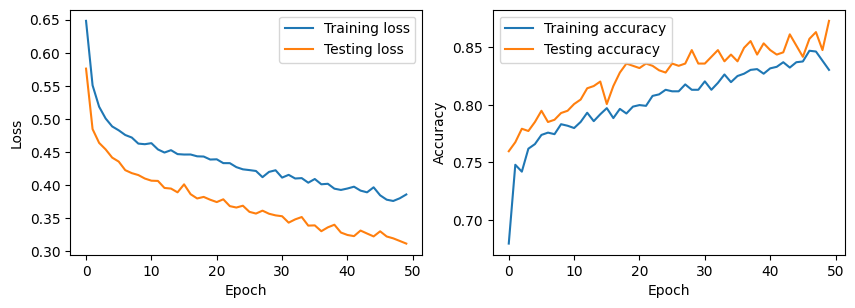

In [27]:
# plot training history
loss = results_dict["loss"]
val_loss = results_dict["val_loss"]

accuracy = results_dict["accuracy"]
val_accuracy = results_dict["val_accuracy"]

epochs_arr = list(range(epochs))

plt.figure(figsize=(10,7))
plt.subplot(2, 2, 1)
plt.plot(epochs_arr, loss, label="Training loss")
plt.plot(epochs_arr, val_loss, label="Testing loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs_arr, accuracy, label="Training accuracy")
plt.plot(epochs_arr, val_accuracy, label="Testing accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(MODEL_DIR.joinpath(f"04_tinyvgg_epochs_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png"))
